# AI Final Project

## Bag of features

In [1]:
#!pip install tensorflow

In [2]:
#import tensorflow as tf
import cv2
import numpy as np
import os
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.cluster.vq import kmeans, vq

In [3]:
raw_data_path = 'data/object-detection/training/image_2/'
raw_data_files = sorted(os.listdir(raw_data_path))[1:]

#test_path = 'data/object-detection/testing/image_2/'
#test_files = sorted(os.listdir(test_path))[1:]

label_path = 'data/object-detection/labels-final/label_2/'
label_files = sorted(os.listdir(label_path))[1:]

def image_list(path):
    return sorted([os.path.join(path, file) for file in os.listdir(path)])[1:]
    
raw_images = image_list(raw_data_path)
#test_images = image_list(test_path)
label_file_paths = image_list(label_path)

image_label_zip = np.array(list(zip(raw_images, label_file_paths)))
train_size = int(len(image_label_zip) * 0.8)
images_split = np.split(image_label_zip, [train_size, len(image_label_zip)])
train_set = images_split[0]
test_set = images_split[1]

In [4]:
# helper function to construct file header string from int
def pad_int(num, desired_length):
    num_str = str(num)
    num_str_len = len(num_str)
    assert num_str_len <= desired_length
    return '0' * (num_str_len - desired_length) + num_str
# set up data structures to store image info

def structure_image_data(image_index):
    file_num_str = pad_int(num=image_index, desired_length=6)
    with open(train_set[image_index][1], 'r') as label_file:
        metadata = []
        for line in label_file:
            split_info = line.split(' ')
            class_label = split_info[0]
            bbox = split_info[4:8]
            metadata.append((class_label, bbox))
    return metadata
        
image_data_structure = {}
for i in range(len(train_set)):
    image_data_structure[pad_int(num=i, desired_length=6)] = structure_image_data(i)
    


In [6]:
# Extract features – SIFT
key_points_list = []
descriptions = []
#sift = cv2.SIFT()
brisk = cv2.BRISK_create(30)
for i in tqdm(range(500)):
    img = cv2.imread(train_set[i][0])
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    key_points, description = brisk.detectAndCompute(grayscale_img, None)
    #key_points_list.append(key_points)
    descriptions.append(description)



100%|██████████| 500/500 [00:44<00:00, 11.25it/s]


In [8]:
stacked_descriptions = descriptions[0]
#stacked_descriptions = np.vstack(descriptions[1:500])

for description in tqdm(descriptions[1:500]):
    stacked_descriptions = np.vstack((stacked_descriptions, description))

stacked_descriptions = stacked_descriptions.astype(float)

100%|██████████| 499/499 [00:23<00:00, 21.21it/s]


In [12]:
# k means clustering
k = 32
voc, var = kmeans(stacked_descriptions, k, 1)

In [13]:
print(voc, var)

[[206.91144301 195.91102059 226.3841744  ...  66.18886626  78.52840009
  105.3926982 ]
 [182.27047355 183.73461768 225.62694146 ... 180.51570816 179.73065331
  159.43933963]
 [126.54111133 125.40711159  77.21550372 ...  66.71486672  79.6128969
  128.27837123]
 ...
 [202.1455284  180.65180218 194.72773228 ... 197.47431814 164.3434264
  113.54133729]
 [181.12852005 157.8404246  201.73153033 ... 104.47873874  92.15759528
  114.74323562]
 [ 81.96876908 106.40100507 122.35383218 ...  55.69565464  79.68192723
  109.58423122]] 620.123557271668


In [17]:
features = np.zeros((500, 32), "float32")
for i in tqdm(range(500)):
    words, dist = vq(descriptions[i], voc)
    for w in words:
        features[i][w] += 1

100%|██████████| 500/500 [00:09<00:00, 54.69it/s]


In [24]:
num_occ = np.sum(features > 0, axis=0)
idf = np.array(np.log(500/num_occ), "float32")

In [60]:
from sklearn.svm import LinearSVC
s = LinearSVC(max_iter=1000000)
print(np.array(list(set([image_data_structure[pad_int(i,6)][0][0] for i in range(500)]))))
s.fit(features, np.array([image_data_structure[pad_int(i,6)][0][0] for i in range(500)]))

['Truck' 'Car' 'Van' 'Cyclist' 'Misc' 'Tram' 'Pedestrian']


/Users/adamcatto/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(max_iter=1000000)

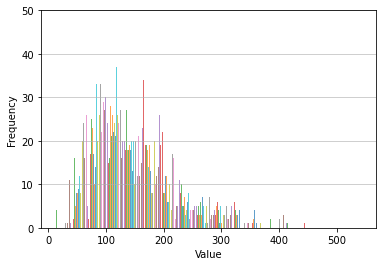

In [19]:
n, bins, patches = plt.hist(x=features, bins='auto',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

### test

In [61]:

def structure_image_data_test(image_index):
    file_num_str = pad_int(num=image_index, desired_length=6)
    with open(test_set[image_index][1], 'r') as label_file:
        metadata = []
        for line in label_file:
            split_info = line.split(' ')
            class_label = split_info[0]
            bbox = split_info[4:8]
            metadata.append((class_label, bbox))
    return metadata
        
image_data_structure_test = {}
for i in range(len(test_set)):
    image_data_structure_test[pad_int(num=i, desired_length=6)] = structure_image_data_test(i)
    


In [33]:
# Extract features – SIFT
key_points_list_test = []
descriptions_test = []
#sift = cv2.SIFT()
brisk = cv2.BRISK_create(30)
for i in tqdm(range(500)):
    img = cv2.imread(test_set[i][0])
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    key_points, description = brisk.detectAndCompute(grayscale_img, None)
    #key_points_list.append(key_points)
    descriptions_test.append(description)



100%|██████████| 500/500 [00:48<00:00, 10.35it/s]


In [34]:
stacked_descriptions_test = descriptions_test[0]
#stacked_descriptions = np.vstack(descriptions[1:500])

for description in tqdm(descriptions_test[1:500]):
    stacked_descriptions_test = np.vstack((stacked_descriptions_test, description))

stacked_descriptions_test = stacked_descriptions_test.astype(float)

100%|██████████| 499/499 [00:30<00:00, 16.57it/s]


In [35]:
features_test = np.zeros((500, 32), "float32")
for i in tqdm(range(500)):
    words, dist = vq(descriptions_test[i], voc)
    for w in words:
        features_test[i][w] += 1

100%|██████████| 500/500 [00:09<00:00, 50.34it/s]


In [65]:
true_classes = [image_data_structure[pad_int(i,6)][0][0] for i in range(500)]
predicted_classes = [x for x in s.predict(features_test)]
correct_predictions = [i for i in range(len(true_classes)) if true_classes[i] == predicted_classes[i]]
print(len(correct_predictions)/len(true_classes))

0.632


==> Accuracy of 63.2%

 ## Bounding Box Regression